In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import random
import glob
import xesmf as xe
from scipy import stats
from sklearn.cross_decomposition import PLSRegression
import matplotlib.cm as cm
from datetime import timedelta, datetime
from scipy import interpolate
from sklearn.preprocessing import MinMaxScaler

def global_average(data_array):
    """
    Find monthly average arctic TAS timeseries.
    """
    lats = np.arange(-88.75, 88.751, 2.5)
    weights = np.cos(np.deg2rad(lats))
    weighted_data_array = np.multiply(data_array, weights[np.newaxis, :, np.newaxis])
    denom = np.nansum(weights)*144 # there are 144 longitudinal grid points
    shape = np.shape(weighted_data_array)
    weighted_data_reshaped = np.reshape(weighted_data_array, (shape[0], shape[1]*shape[2]))
    weighted_sum = np.nansum(weighted_data_reshaped, axis=1)
    weighted_average = np.divide(weighted_sum, denom)
    return(weighted_average)

def arctic_average(data_array, lats):
    """
    Find monthly average arctic TAS timeseries.
    """
    weights = np.cos(np.deg2rad(lats))[64:]
    weighted_data_array = np.multiply(data_array[:,64:,:], weights[np.newaxis, :, np.newaxis])
    denom = np.nansum(weights)*144 # there are 144 longitudinal grid points
    shape = np.shape(weighted_data_array)
    weighted_data_reshaped = np.reshape(weighted_data_array, (shape[0], shape[1]*shape[2]))
    weighted_sum = np.nansum(weighted_data_reshaped, axis=1)
    weighted_average = np.divide(weighted_sum, denom)
    return(weighted_average)

def storer(set_of_files):
    X_data = []
    Y_data = []
    model_names = []
    for model in set_of_files:
        model_name = model.split('/')[-1][:-3]
        CM = xr.open_dataset(model)
        CM = CM.sel(period=slice(1900,2050))
        X_CM = CM.X_TAS_and_PSL.values
        X_CM_ = X_CM[:,:,:,:,0]
        X_CM_external = np.nanmean(X_CM_, axis=0)
        X_CM_internal = X_CM_ - X_CM_external
        X_CM_internal_maps = np.reshape(X_CM_internal, (X_CM_internal.shape[0]*X_CM_internal.shape[1], X_CM_internal.shape[2], X_CM_internal.shape[3]))
        X_CM_external_maps = np.reshape(X_CM_external, (X_CM_external.shape[0], X_CM_external.shape[1], X_CM_external.shape[2]))
        global_average_TAS_internal = [global_average(map_item)[0] for map_item in X_CM_internal_maps]
        global_average_TAS_internal = np.reshape(global_average_TAS_internal, X_CM_internal.shape[:-2])
        global_average_TAS_external = [global_average(map_item)[0] for map_item in X_CM_external_maps]
        global_average_TAS_external = np.reshape(global_average_TAS_external, X_CM_external.shape[:-2])
        Y_CM = [[global_average_TAS_internal[i], global_average_TAS_external] for i in range(len(global_average_TAS_internal))]
        Y_CM = np.swapaxes(Y_CM, 1,2)
        X_data.append(X_CM)
        Y_data.append(np.array(Y_CM))
        CM.close()
        model_names.append(model_name)
    return(X_data, Y_data, model_names)


# define file path to historical and spliced simulations
cmip6_hist = glob.glob('/home/disk/pna2/aodhan/CESM2_LENS/CMIP6_70_trends_historical/*')
cmip6_spliced = glob.glob('/home/disk/pna2/aodhan/CESM2_LENS/CMIP6_70_trends_spliced_extended/*')

# Delete the 'OthersAllEM' data
cmip6_hist = [s for s in cmip6_hist if 'OthersAllEM' not in s] 
cmip6_spliced = [s for s in cmip6_spliced if 'OthersAllEM' not in s] 

# get historical simulations which do not have extension past 2014
hist_not_spliced = []
model_names = [cmip6_spliced[i].split('/')[7] for i in range(len(cmip6_spliced))]
for filename in cmip6_hist:
    model_name = filename.split('/')[7]
    extended_models = [cmip6_spliced[i].split('/')[7] for i in range(len(cmip6_spliced))]
    if model_name in extended_models:
        continue
    else:
        hist_not_spliced.append(filename)
    
# store data
hist_no_splice_X, hist_no_splice_Y, model_names_hist_no_splice = storer(hist_not_spliced)
splice_X, splice_Y, model_names_spliced = storer(cmip6_spliced)

# select subset of data
hist_no_splice_X_cut = []
splice_X_cut = []
for data in hist_no_splice_X:
    data_to_keep = data[:,:,:,:,0]
    hist_no_splice_X_cut.append(data_to_keep)
for data in splice_X:
    data_to_keep = data[:,:,:,:,0]
    splice_X_cut.append(data_to_keep)

# free up space
del hist_no_splice_X
del splice_X

# reorganize models by their arctic warming 
models_reorgainzed = ['CESM2_SBMB', 'CESM2', 'ACCESS-ESM1-5', 'MPI-ESM1-2-LR', 'IPSL-CM6A-LR', 'MIROC6', 'CanESM5']
ranked_arctic_warming_indices = []
for model_name in models_reorgainzed:
    new_ranked_indices = model_names_spliced.index(model_name)
    ranked_arctic_warming_indices.append(new_ranked_indices)
splice_X_cut = [splice_X_cut[i] for i in ranked_arctic_warming_indices]
splice_Y = [splice_Y[i] for i in ranked_arctic_warming_indices]
model_names_spliced = [model_names_spliced[i] for i in ranked_arctic_warming_indices]


In [2]:
def Trend_of_data(x):
    end = len(x)/10
    decades = np.arange(0,end,0.1)
    return np.polyfit(decades, x, deg=1)[0]
def convert_partial_year(number):
    year = int(number)
    d = timedelta(days=(number - year)*365)
    day_one = datetime(year,1,1)
    date = d + day_one
    return date
    
def ERA5_loader():
    # load ERA5
    ERA5_monthly = xr.open_dataset('/home/disk/p/aodhan/SurfaceTrendLearing/AllSeasonExperiments/insitu_Arctic/ERA5_1979_2022_TAS_PSL.nc')    
    ERA5_monthly = ERA5_monthly.sel(time=slice('1980', '2022'))

    # temp
    ERA5_temp = ERA5_monthly.t2m.values
    ERA5_temp_cal = ERA5_temp.reshape(43,12,73,144)
    ERA5_temp_cal = np.nanmean(ERA5_temp_cal, axis=1)
    
    # psl
    ERA5_psl = ERA5_monthly.msl.values
    ERA5_psl_cal = ERA5_psl.reshape(43,12,73,144)
    ERA5_psl_cal = np.nanmean(ERA5_psl_cal, axis=1)

    # set up regridder, note that TAS and PSL have same shape
    latitudes = ERA5_monthly.latitude.values
    longitudes = ERA5_monthly.longitude.values
    InputGrid = {"lon": longitudes, "lat": latitudes}
    OutputGrid = {"lon": np.arange(1.25, 358.751, 2.5), "lat": np.arange(-88.75, 88.751, 2.5)}
    regridder = xe.Regridder(InputGrid, OutputGrid, "bilinear", periodic=True)

    # regrid the TAS and PSL data
    TAS_2p5x2p5 = regridder(ERA5_temp_cal)
    PSL_2p5x2p5 = regridder(ERA5_psl_cal)
    ERA5_TAS_PSL = np.stack([TAS_2p5x2p5, PSL_2p5x2p5], axis=-1)
    return(ERA5_TAS_PSL)

def Hadcrut_loader():
    Hadcrut = xr.open_dataset('/home/disk/p/aodhan/SurfaceTrendLearing/AllSeasonExperiments/insitu_Arctic/HadCRUT.5.0.1.0.analysis.anomalies.ensemble_mean.nc')
    Had_crut_1978_2023 = Hadcrut.sel(time=slice('1980', '2022'))

    # set up regridder
    latitudes = Had_crut_1978_2023.latitude.values
    longitudes = Had_crut_1978_2023.longitude.values
    InputGrid = {"lon": longitudes, "lat": latitudes}
    OutputGrid = {"lon": np.arange(1.25, 358.751, 2.5), "lat": np.arange(-88.75, 88.751, 2.5)}
    regridder = xe.Regridder(InputGrid, OutputGrid, "bilinear", periodic=True, reuse_weights=False)
    Hadcrut_regridded = regridder(Had_crut_1978_2023.tas_mean.values)
    Hadcrut_regridded = Hadcrut_regridded
    Hadcrut_cal = np.reshape(Hadcrut_regridded, (int(len(Hadcrut_regridded)/12), 12, Hadcrut_regridded.shape[1], Hadcrut_regridded.shape[2]))
    Hadcrut_annual_mean = np.nanmean(Hadcrut_cal, axis=1)
    return(Hadcrut_annual_mean)

def berkeley_loader():
    berkely = xr.open_dataset('/home/disk/p/aodhan/SurfaceTrendLearing/AllSeasonExperiments/insitu_Arctic/BerkelyEarthTAS.nc')
    berkely['time'] = [convert_partial_year(time) for time in berkely['time'].values]
    berkely_1978_2023 = berkely.sel(time=slice('1980', '2022'))
    # set up regridder
    latitudes = berkely_1978_2023.latitude.values
    longitudes = berkely_1978_2023.longitude.values
    InputGrid = {"lon": longitudes, "lat": latitudes}
    OutputGrid = {"lon": np.arange(1.25, 358.751, 2.5), "lat": np.arange(-88.75, 88.751, 2.5)}
    regridder = xe.Regridder(InputGrid, OutputGrid, "bilinear", periodic=True)
    berkely_regridded = regridder(berkely_1978_2023)
    berkely_regridded = berkely_regridded.temperature.values
    berkely_cal = np.reshape(berkely_regridded, (int(len(berkely_regridded)/12), 12, berkely_regridded.shape[1], berkely_regridded.shape[2]))
    berkely_annual_mean = np.nanmean(berkely_cal, axis=1)
    return(berkely_annual_mean)

def GIST_loader():
    GIST = xr.open_dataset('/home/disk/p/aodhan/SurfaceTrendLearing/AllSeasonExperiments/insitu_Arctic/gistemp1200_GHCNv4_ERSSTv5.nc')
    GIST_1978_2023 = GIST.sel(time=slice('1980', '2022'))
    # set up regridder
    latitudes = GIST_1978_2023.lat.values
    longitudes = GIST_1978_2023.lon.values
    InputGrid = {"lon": longitudes, "lat": latitudes}
    OutputGrid = {"lon": np.arange(1.25, 358.751, 2.5), "lat": np.arange(-88.75, 88.751, 2.5)}
    regridder = xe.Regridder(InputGrid, OutputGrid, "bilinear", periodic=True)
    GIST_regridded = regridder(GIST_1978_2023.tempanomaly)
    GIST_regridded = GIST_regridded.values
    GIST_cal = np.reshape(GIST_regridded, (int(len(GIST_regridded)/12), 12, GIST_regridded.shape[1], GIST_regridded.shape[2]))
    GIST_annual_mean = np.nanmean(GIST_cal, axis=1)
    return(GIST_annual_mean)

def NOAA_loader():
    NOAA = xr.open_dataset('/home/disk/p/aodhan/SurfaceTrendLearing/AllSeasonExperiments/insitu_Arctic/NOAAGlobalTempV5.nc')
    NOAA_1978_2023 = NOAA.sel(time=slice('1980', '2022'))
    # set up regridder
    latitudes = NOAA_1978_2023.lat.values
    longitudes = NOAA_1978_2023.lon.values
    InputGrid = {"lon": longitudes, "lat": latitudes}
    OutputGrid = {"lon": np.arange(1.25, 358.751, 2.5), "lat": np.arange(-88.75, 88.751, 2.5)}
    regridder = xe.Regridder(InputGrid, OutputGrid, "bilinear", periodic=True)
    NOAA_1978_2023 = NOAA_1978_2023.sel(z=0.0)
    NOAA_regridded = regridder(NOAA_1978_2023)
    NOAA_regridded = NOAA_regridded.anom.values
    NOAA_cal = np.reshape(NOAA_regridded, (int(len(NOAA_regridded)/12), 12, NOAA_regridded.shape[1], NOAA_regridded.shape[2]))
    NOAA_annual_mean = np.nanmean(NOAA_cal, axis=1)
    return(NOAA_annual_mean)

def JRA55_loader():
    JRA55 = xr.open_dataset('/home/disk/pna2/aodhan/JRA55_1958_2023_SLP_TAS.nc')
    JRA55 = JRA55.sel(time=slice('1980', '2022'))

    psl = JRA55.Pressure_reduced_to_MSL_msl_Average.values
    psl_cal = psl.reshape(43,12,145,288)
    psl_cal = np.nanmean(psl_cal, axis=1)

    # set up regridder for PSL
    latitudes = JRA55.latitude.values
    longitudes = JRA55.longitude.values
    InputGrid = {"lon": longitudes, "lat": latitudes}
    OutputGrid = {"lon": np.arange(1.25, 358.751, 2.5), "lat": np.arange(-88.75, 88.751, 2.5)}
    regridder = xe.Regridder(InputGrid, OutputGrid, "bilinear", periodic=True)
    PSL_2p5x2p5 = regridder(psl_cal)
    return(np.array(PSL_2p5x2p5))

def MERRA2_loader():
    netcdf_files = []
    for file_name in glob.glob('/home/disk/pna2/aodhan/MERRA2_SLP/*'):
        MERRA2_month = xr.open_dataset(file_name, engine='netcdf4')
        netcdf_files.append(MERRA2_month)
        MERRA2_month.close()    
    MERRA2 = xr.concat(netcdf_files, dim='time')
    MERRA2 = MERRA2.sortby('time')
    psl = MERRA2.SLP.values
    psl_cal = psl.reshape(43,12,361,576)
    psl_cal = np.nanmean(psl_cal, axis=1)

    # set up regridder for PSL
    latitudes = MERRA2.lat.values
    longitudes = MERRA2.lon.values
    InputGrid = {"lon": longitudes, "lat": latitudes}
    OutputGrid = {"lon": np.arange(1.25, 358.751, 2.5), "lat": np.arange(-88.75, 88.751, 2.5)}
    regridder = xe.Regridder(InputGrid, OutputGrid, "bilinear", periodic=True)
    PSL_2p5x2p5 = regridder(psl_cal)
    return(np.array(PSL_2p5x2p5))

def NCEP_loader():
    NCEP = xr.open_dataset('/home/disk/pna2/aodhan/NCEP2_SLPMonthly.nc')
    NCEP = NCEP.sel(time=slice('1980', '2022'))
    psl = NCEP.mslp.values
    psl_cal = psl.reshape(43,12,73,144)
    psl_cal = np.nanmean(psl_cal, axis=1)

    # set up regridder for PSL
    latitudes = NCEP.lat.values
    longitudes = NCEP.lon.values
    InputGrid = {"lon": longitudes, "lat": latitudes}
    OutputGrid = {"lon": np.arange(1.25, 358.751, 2.5), "lat": np.arange(-88.75, 88.751, 2.5)}
    regridder = xe.Regridder(InputGrid, OutputGrid, "bilinear", periodic=True)
    PSL_2p5x2p5 = regridder(psl_cal)
    return(np.array(PSL_2p5x2p5))

#lat index
lat_idx = 0

# load datasets
ERA5_TAS_PSL = ERA5_loader()
ERA5_trends = np.apply_along_axis(func1d=Trend_of_data, axis=0, arr=ERA5_TAS_PSL)
ERA5_trends = ERA5_trends[lat_idx:]
ERA5_PSL = ERA5_TAS_PSL[:,lat_idx:,:,1]
ERA5_TAS = ERA5_TAS_PSL[:,lat_idx:,:,0]
berkeley_TAS = berkeley_loader()[:,lat_idx:,:]
GIST_TAS = GIST_loader()[:,lat_idx:,:]
NOAA_TAS = NOAA_loader()[:,lat_idx:,:]
HadCrut_TAS = Hadcrut_loader()[:,lat_idx:,:]
NCEP_PLS = NCEP_loader()[:,lat_idx:,:]
JRA55_PLS = JRA55_loader()[:,lat_idx:,:]
MERRA2_PLS = MERRA2_loader()[:,lat_idx:,:]
TAS_observations = [HadCrut_TAS, berkeley_TAS, GIST_TAS, NOAA_TAS]
SLP_observations = [ERA5_PSL, MERRA2_PLS]

obs_tas_slp_maps = []
for tas_array in TAS_observations:
    tas_and_slp_maps = tas_array
    trend_maps = np.apply_along_axis(func1d=Trend_of_data, axis=0, arr=tas_and_slp_maps)
    obs_tas_slp_maps.append(trend_maps)
obs_tas_maps = np.array(obs_tas_slp_maps)

/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/xesmf/frontend.py:602: UserWarning: Using dimensions ('latitude', 'longitude') from data variable land_mask as the horizontal dimensions for the regridding.
  UserWarning,
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/xesmf/frontend.py:602: UserWarning: Using dimensions ('lat', 'lon') from data variable tempanomaly as the horizontal dimensions for the regridding.
  UserWarning,
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:84: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/xesmf/frontend.py:602: UserWarning: Using dimensions ('lat', 'lon') from data variable anom as the horizontal dimensions for the regridding.
  UserWarning,
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:53: RuntimeWarning: Mean of empty slice
/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/xesmf/backend.py:53: UserWarning: Lat

In [3]:
obs_maps_new = []
for map_item in range(0,len(obs_tas_maps)):
    #mask invalid values
    array = np.ma.masked_invalid(obs_tas_maps[map_item])
    xx, yy = np.meshgrid(np.arange(1.25, 358.751, 2.5), np.arange(-88.75, 88.751, 2.5))
    #get only the valid values
    x1 = xx[~array.mask]
    y1 = yy[~array.mask]
    newarr = array[~array.mask]
    GD1 = interpolate.griddata((x1, y1), newarr.ravel(),(xx, yy), method='cubic')
    obs_maps_new.append(GD1)
obs_maps = np.array(obs_maps_new)
#obs_maps = np.stack([obs_maps, obs_slp_maps], axis=-1)
#obs_maps = obs_maps[:,:,:,0]

# PLS

In [4]:
# define min max scalers for use
Xscale = MinMaxScaler()
Yscale = MinMaxScaler()

# set the arrays for which to store all PLS results
cv_preds_and_vals = []
cv_obs = []
coef_maps = []
cv_mse = []
predictions_error = []

# loop through possible PLS components
for pls_idx in np.arange(3,4,1):
    pls = PLSRegression(n_components=pls_idx, scale=False)
    
    # create arrays for which to store one PLS result
    cv_preds_and_vals_one_pls = []
    cv_obs_one_pls = []
    cv_mse_one_pls = []

    # loop through each large ensemble we test on (cv = cross validation)
    for cv in range(len(splice_X_cut)):
        print('Predicting: ', model_names_spliced[cv])

        cv_preds_and_vals_one_randomization = []
        cv_obs_one_randomization = []
        cv_mse_one_randomization = []
        coef_maps_one_randomization = []

        for randomization in range(10):
            # equally weight training data from different models
            splice_X_10ens = []
            splice_Y_10ens = []
            hist_X_10ens = []
            hist_Y_10ens = []

            # select first 10 ensemble members to train on from ensembles with more than 10 members
            for model_idx in range(len(splice_X_cut)):
                model_X = splice_X_cut[model_idx]
                model_Y = splice_Y[model_idx]
                random_indices = np.random.choice(range(0, len(model_X)), size=10, replace=True)
                splice_X_10ens.append(model_X[random_indices])
                splice_Y_10ens.append(model_Y[random_indices])
            for model_idx in range(len(hist_no_splice_X_cut)):
                model_X = hist_no_splice_X_cut[model_idx]
                model_Y = hist_no_splice_Y[model_idx]
                random_indices = np.random.choice(range(0, len(model_X)), size=10, replace=True)
                hist_X_10ens.append(model_X[random_indices])
                hist_Y_10ens.append(model_Y[random_indices])
            
            # define training data
            X_train_spliced = np.concatenate(np.delete(splice_X_10ens, cv, axis=0), axis=0)
            Y_train_spliced = np.concatenate(np.delete(splice_Y_10ens, cv, axis=0), axis=0)
            X_train_hist = np.concatenate(hist_X_10ens, axis=0)
            Y_train_hist = np.concatenate(hist_Y_10ens, axis=0)

            # reshape to put ensembles and time periods in same axis
            X_train_spliced = X_train_spliced.reshape(X_train_spliced.shape[0]*X_train_spliced.shape[1], X_train_spliced.shape[2], X_train_spliced.shape[3])#, X_train_spliced.shape[4])
            X_train_hist = X_train_hist.reshape(X_train_hist.shape[0]*X_train_hist.shape[1], X_train_hist.shape[2], X_train_hist.shape[3])#, X_train_hist.shape[4])
            Y_train_spliced = Y_train_spliced.reshape(Y_train_spliced.shape[0]*Y_train_spliced.shape[1], Y_train_spliced.shape[2])
            Y_train_hist = Y_train_hist.reshape(Y_train_hist.shape[0]*Y_train_hist.shape[1], Y_train_hist.shape[2])

            # concatenate and reshape training data
            X_train = np.concatenate([X_train_spliced, X_train_hist], axis=0)
            Y_train = np.concatenate([Y_train_spliced, Y_train_hist], axis=0)
            X_train_reshaped = X_train.reshape(X_train.shape[0], X_train.shape[1]*X_train.shape[2])#*X_train.shape[3])
            Y_train_reshaped = Y_train[:,:2]

            # define testing data, the -6 time period is 1979-2023
            X_test = splice_X_cut[cv][:,-6]
            #X_test = X_test.reshape(X_test.shape[0]*X_test.shape[1], X_test.shape[2], X_test.shape[3])#, X_test.shape[4])
            X_test_reshaped = X_test.reshape(X_test.shape[0], X_test.shape[1]*X_test.shape[2])#*X_test.shape[3])
            Y_test = splice_Y[cv][:,-6,:]
            #Y_test = Y_test.reshape(Y_test.shape[0]*Y_test.shape[1], Y_test.shape[2])
            Y_test = Y_test[:,:2]

            # scale training and testing data
            Xscale.fit(X_train_reshaped)
            Yscale.fit(Y_train_reshaped)
            X_train_scaled = Xscale.transform(X_train_reshaped)
            X_test_scaled = Xscale.transform(X_test_reshaped)
            Y_train_scaled = Yscale.transform(Y_train_reshaped)
            Y_test_scaled = Yscale.transform(Y_test)
            
            # fit PLS model
            pls.fit(X_train_scaled, Y_train_scaled)
            coef_maps_one_randomization.append(pls.coef_)


            # make predictions on testing data
            Y_pred_scaled = pls.predict(X_test_scaled)
            Y_preds_unscaled = Yscale.inverse_transform(Y_pred_scaled)
            Y_pred = np.transpose(Y_preds_unscaled).tolist()
            Y_test_one_model = np.transpose(Y_test).tolist()
            sum_preds = np.nansum(Y_pred, axis=0)
            sum_test = np.nansum(Y_test_one_model, axis=0)
            Y_pred.append(sum_preds)
            Y_test_one_model.append(sum_test)
            cv_preds_and_vals_one_randomization.append([np.transpose(Y_pred), np.transpose(Y_test_one_model)])
            
            # make predictions on observations
            X_obs_reshaped = obs_maps.reshape(obs_maps.shape[0], obs_maps.shape[1]*obs_maps.shape[2])#*obs_maps.shape[3])
            X_obs_scaled = Xscale.transform(X_obs_reshaped)
            obs_Y_pred_scaled = pls.predict(X_obs_scaled)
            obs_Y_pred_unscaled = Yscale.inverse_transform(obs_Y_pred_scaled)
            Y_obs = np.transpose(obs_Y_pred_unscaled).tolist()
            sum_obs = np.nansum(Y_obs, axis=0)
            Y_obs.append(sum_obs)
            cv_obs_one_randomization.append(Y_obs)
        
        mean_of_randomizations_val = np.nanmean(cv_preds_and_vals_one_randomization, axis=0)
        mean_of_randomizations_obs = np.nanmean(cv_obs_one_randomization, axis=0)
        error = mean_of_randomizations_val[0] - mean_of_randomizations_val[1]

        cv_preds_and_vals_one_pls.append(mean_of_randomizations_val)
        cv_obs_one_pls.append(mean_of_randomizations_obs)
        coef_maps.append(np.nanmean(coef_maps_one_randomization, axis=0))
        predictions_error.append(error)

    cv_preds_and_vals.append(cv_preds_and_vals_one_pls)
    cv_obs.append(cv_obs_one_pls)

Predicting:  CESM2_SBMB
Predicting:  CESM2
Predicting:  ACCESS-ESM1-5
Predicting:  MPI-ESM1-2-LR
Predicting:  IPSL-CM6A-LR
Predicting:  MIROC6
Predicting:  CanESM5


In [5]:
std_errors = []
new_errors = []
for error in predictions_error:
    error_var = error #- np.nanmean(error, axis=0)
    squared_error = np.multiply(error_var, error_var)
    
    error_new = squared_error*(1/len(squared_error))
    new_errors.append(error_new)

    #std_errors.append(np.nanstd(error, axis=0))
new_errors_all = np.concatenate(new_errors)
new_errors_sum = np.nansum(new_errors_all, axis=0)
new_errors_mean = new_errors_sum/7
new_errors_std = np.sqrt(new_errors_mean)
print(new_errors_std)


[0.02439777 0.02628654 0.00468732]


In [7]:
thing = np.concatenate(predictions_error, axis=0)
std_thing = np.nanstd(thing, axis=0)
print(np.nanstd(thing, axis=0))

[0.02166021 0.02254689 0.00388229]


In [8]:
cv_preds_and_vals_ = cv_preds_and_vals[0]
cv_obs_ = cv_obs[0]
cv_obs_1 = np.swapaxes(cv_obs_, 0,2)


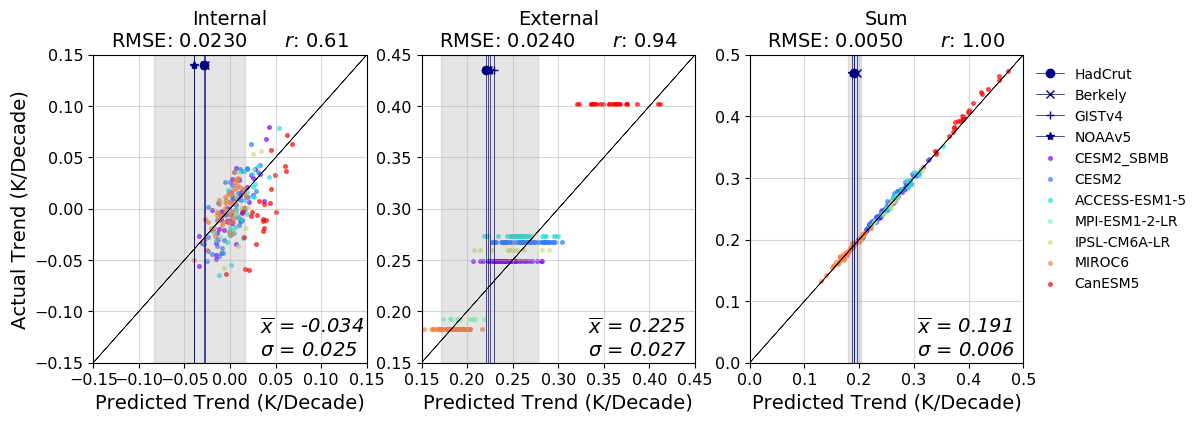

In [11]:
# Create labels and colors
titles = ['Internal', 'External', 'Sum']
obs_labels = ['HadCrut', 'Berkely', 'GISTv4', 'NOAAv5']
obs_colors = ['palegreen', 'coral', 'deepskyblue', 'orchid', 'gold']
obs_markers = ['o', 'x', '+', '*', 'd']
marker_loc = [0.14, .435, .47]
colors = cm.rainbow(np.linspace(0, 1, 7))

# make subplot
fig, axs = plt.subplots(1,3, figsize=(12,4), facecolor='white')

# select cv data
cv_preds_and_vals_ = cv_preds_and_vals[0]
cv_obs_1_by_obs = np.swapaxes(cv_obs[0], 0, 2)


for trend_comp in range(3):
    # ravel all observational estimates from cv for a given component and find mean/spread and plot it
    all_obs_spread = np.nanmean(cv_obs_1_by_obs[:,trend_comp,:], axis=1).ravel()
    all_obs_mean = np.nanmean(all_obs_spread)
    all_obs_sigma = np.nanstd(all_obs_spread)
    sigma_2 = new_errors_std[trend_comp]
    all_obs_sigma = np.sqrt(all_obs_sigma**2 + sigma_2**2)
    obs_mean = str(round(all_obs_mean, 3))
    obs_std = str(round(all_obs_sigma, 3))
    axs[trend_comp].axvspan(all_obs_mean - 2*all_obs_sigma, all_obs_mean + 2*all_obs_sigma, color='grey', alpha=0.2)
    text_item = '$\overline{x}$ = ' + obs_mean + '\n$\sigma$ = ' + obs_std
    axs[trend_comp].text(0.61, 0.15, text_item, transform=axs[trend_comp].transAxes,
            fontsize=14, style='italic', va='top', ha='left')

    # for each set of observations, find the mean
    cv_obs_set = cv_obs_1_by_obs[:,trend_comp,:]
    y_spaces = [[-0.15,0.151], [.15,.451], [0.0,.51]]
    for obs_set_idx in range(len(cv_obs_set)):
        obs_set_all_cv = cv_obs_set[obs_set_idx]
        mean_obs = np.nanmean(obs_set_all_cv)
        y_spacing = y_spaces[trend_comp]
        axs[trend_comp].plot(np.repeat(mean_obs, 3), [-5, marker_loc[trend_comp], 5], color='navy', marker=obs_markers[obs_set_idx], label=obs_labels[obs_set_idx], linewidth=0.5)
        
# for each iteration of the cross validation find predictions and validations (test)
for model_idx, set_of_preds_and_vals in enumerate(cv_preds_and_vals_):
    Y_pred_ = np.array(set_of_preds_and_vals[0])
    Y_test_ = np.array(set_of_preds_and_vals[1])

    for trend_comp in range(3):
        # for each component of trend, plot the scatter
        axs[trend_comp].scatter(Y_pred_[:,trend_comp], Y_test_[:,trend_comp], color=colors[model_idx], s=7, alpha=0.6, label=model_names_spliced[model_idx])
        
        # also plot the prediction = validation line
        axs[trend_comp].plot(np.linspace(-2,2.5), np.linspace(-2,2.5), color='black', linewidth=0.25)

        # use varying x and y lims for each component
        if trend_comp == 0:
            ticks = np.arange(-0.15,0.151, 0.05)
            axs[trend_comp].set_xticks(ticks)
            axs[trend_comp].set_yticks(ticks)
            axs[trend_comp].set_ylim(ticks[0],ticks[-1])
            axs[trend_comp].set_xlim(ticks[0],ticks[-1])
        if trend_comp == 1:
            ticks = np.arange(0.15,0.451, 0.05)
            axs[trend_comp].set_xticks(ticks)
            axs[trend_comp].set_yticks(ticks)
            axs[trend_comp].set_ylim(ticks[0],ticks[-1])
            axs[trend_comp].set_xlim(ticks[0],ticks[-1])
        if trend_comp == 2:
            ticks = np.arange(.0,0.51, 0.1)
            axs[trend_comp].set_xticks(ticks)
            axs[trend_comp].set_yticks(ticks)
            axs[trend_comp].set_ylim(ticks[0],ticks[-1])
            axs[trend_comp].set_xlim(ticks[0],ticks[-1])
    
    
# Give scores across all models and ensemble members from 1980-2022 period
all_preds_and_vals = np.concatenate(cv_preds_and_vals_, axis=1)
for trend_comp in range(3):
    # Again, get predictions and validations
    Y_pred_ = all_preds_and_vals[0]
    Y_test_ = all_preds_and_vals[1]

    # find MSE for trend components
    MSE = np.nanmean(np.square(Y_pred_[:,trend_comp] - Y_test_[:,trend_comp]), axis=0)
    MSE_str = str(np.around(MSE,5))
    
    # find r for trend components
    r = stats.pearsonr(Y_pred_[:,trend_comp], Y_test_[:,trend_comp])[0]
    r_str = str(np.around(r, 3))

    # put MSE and r in title
    axs[trend_comp].set_title(titles[trend_comp] + '\nRMSE: {:.4f}'.format(round(np.sqrt(MSE),3))  + '      $r$: {:.2f}'.format(round(r,2)), fontsize=14)

    # put labels on plots
    axs[trend_comp].set_xlabel('Predicted Trend (K/Decade)', fontsize=14)
    axs[0].set_ylabel('Actual Trend (K/Decade)', fontsize=14)
    axs[trend_comp].grid(alpha=0.5)
    axs[trend_comp].tick_params(axis='both', labelsize=11.5)


axs[2].legend(loc='upper left', bbox_to_anchor=(1., 1.0), frameon=False)

#plt.savefig('/home/disk/p/aodhan/SurfaceTrendLearing/AllSeasonExperiments/figures/PLS_Global_TAS.png', dpi=300, bbox_inches="tight", facecolor=fig.get_facecolor())


In [9]:
np.shape(coef_maps)

(7, 10368, 2)

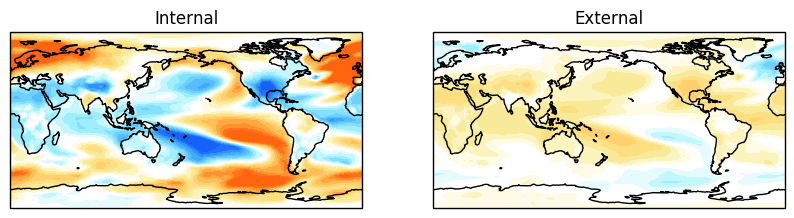

In [14]:
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

# find average coefficient map
mean_coef_map = np.nanmean(coef_maps, axis=0)
mean_coef_maps = mean_coef_map.T
mean_coef_maps_2d = np.reshape(mean_coef_maps, (2,72,144))

lat_bins = np.linspace(-90, 90., 72)
lon_bins = np.linspace(0, 360, 144)
lim = np.linspace(-.001, .001, 21)
subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=180))
obs_names = ['Internal', 'External']

fig, axs = plt.subplots(1, 2, figsize=(10, 4), subplot_kw=subplot_kw)
axs_items = axs.flatten()
for obs_idx, model_set in enumerate(mean_coef_maps_2d):
    map_cyclic, lon = add_cyclic_point(model_set, coord=lon_bins)
    axs_items[obs_idx].set_title(obs_names[obs_idx])
    axs_items[obs_idx].coastlines()
    im = axs_items[obs_idx].contourf(lon, lat_bins, map_cyclic, 20, levels=lim,
                    transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)

#cbar_ax = fig.add_axes([0.0, 0.0, 0.8, 0.05])
#cb = fig.colorbar(im,  orientation='horizontal', cax=cbar_ax)
#cb.ax.set_xlabel('SLP trend (Pa/Dec)', fontsize=15)
#cb.ax.tick_params(labelsize=15) 
    

In [ ]:
all_pls_1980_2022 = []
for indx in range(0, len(np.arange(2,21,2))):
    all_cv_1980_2022 = []
    for cv in range(0, len(cv_preds_and_vals[indx])):

        test_data = np.reshape(cv_preds_and_vals[indx][cv], (2, np.shape(splice_Y[cv])[0], np.shape(splice_Y[cv])[1], 3))
        cv_preds_and_vals_19802022 = test_data[:,:,-6,:]
        all_cv_1980_2022.append(cv_preds_and_vals_19802022)
        
    all_pls_1980_2022.append(all_cv_1980_2022)

In [5]:
metrics_by_pls_comp = []
for idx in range(len(cv_preds_and_vals)):
    #cv_preds_and_vals_1980_2022_range = all_pls_1980_2022[idx]
    cv_preds_and_vals_ = cv_preds_and_vals[idx]
    cv_obs_ = cv_obs[idx]
    all_mses = []
    for cv in range(0, len(cv_preds_and_vals_)):
        preds = cv_preds_and_vals_[cv][0]
        vals  = cv_preds_and_vals_[cv][1]

        #preds_1980 = cv_preds_and_vals_1980_2022_range[cv][0]
        #vals_1980 = cv_preds_and_vals_1980_2022_range[cv][1]

        obs_preds = np.array(cv_obs_[cv])
        mse_each_cv = []
        obs_pred_cv = []
        for trend_comp in range(3):
            mse = np.nanmean(np.square(preds[:,trend_comp] - vals[:,trend_comp]), axis=0)
            #mse_1980_2022 = np.nanmean(np.square(preds_1980[:,trend_comp] - vals_1980[:,trend_comp]), axis=0)
            mean_obs_pred = np.nanmean(obs_preds[trend_comp])
            #slope = stats.linregress(preds_1980[:,trend_comp], vals_1980[:,trend_comp])[0]
            #r = stats.pearsonr(preds_1980[:,trend_comp], vals_1980[:,trend_comp])[0]
            mse_each_cv.append([mse, mean_obs_pred, mse, mse, mse])
        all_mses.append(mse_each_cv)
    metrics_by_pls_comp.append(all_mses)
    #all_preds_and_vals = np.concatenate(cv_preds_and_vals_, axis=1)

metrics_by_pls_comp = np.array(metrics_by_pls_comp)

No handles with labels found to put in legend.


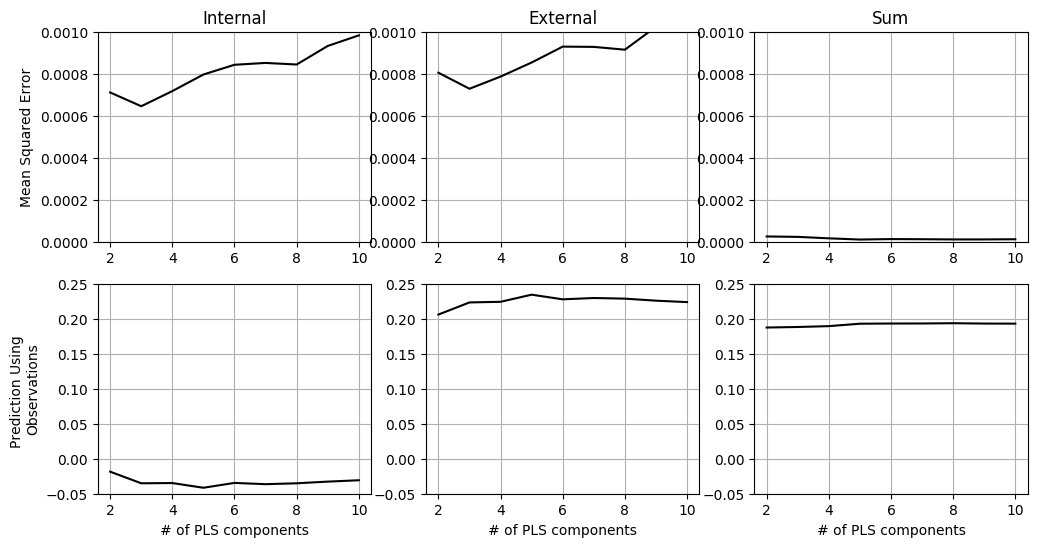

In [6]:
n_comp_range = np.arange(2,11,1)

fig, axs = plt.subplots(2,3, figsize=(12,6))
titles = ['Internal', 'External', 'Sum']
for row in range(2):
    for column in range(3):
        if row == 0:
            axs[row,column].plot(n_comp_range, np.nanmean(metrics_by_pls_comp[:,:,column,0], axis=1), color='black')
            #axs[row,column].plot(n_comp_range, np.nanmean(metrics_by_pls_comp[:,:,column,2], axis=1), color='red', label='Average MSE (1980-2022)')
            axs[row, column].set_ylim(0.0000,0.001)
            axs[row, 0].set_ylabel('Mean Squared Error')
            axs[row, column].set_title(titles[column])
            if column == 2:
                axs[row, column].legend(frameon=False)

        #if row == 1:
        #    #axs[row,column].plot(n_comp_range, np.nanmean(metrics_by_pls_comp[:,:,column,3], axis=1), color='black', label='Slope')
        #    axs[row,column].plot(n_comp_range, np.nanmean(metrics_by_pls_comp[:,:,column,4], axis=1), color='black', label='r')
        #    axs[row, column].set_ylim(0.75,1.25)
        #    axs[row, 0].set_ylabel('Slope & Correlation \nCoefficient')
        #    axs[row, column].set_xlabel('# of PLS components')
        #    if column == 2:
        #        axs[row, column].legend(frameon=False)

        if row == 1:
            axs[row,column].plot(n_comp_range, np.nanmean(metrics_by_pls_comp[:,:,column,1], axis=1), color='black')
            #axs[row,column].plot(np.arange(2,20,2), np.nanstd(metrics_by_pls_comp[:,:,column,1], axis=1)[:20], color='red')
            axs[row, column].set_ylim(-0.05,0.25)
            axs[row, 0].set_ylabel('Prediction Using \nObservations')
            axs[row, column].set_xlabel('# of PLS components')
        axs[row,column].grid()




In [18]:
np.shape(metrics_by_pls_comp[:,:,column,1])

(8, 7)

In [17]:
metrics_by_pls_comp = np.array(metrics_by_pls_comp)
np.shape(metrics_by_pls_comp)

(15, 3, 4)

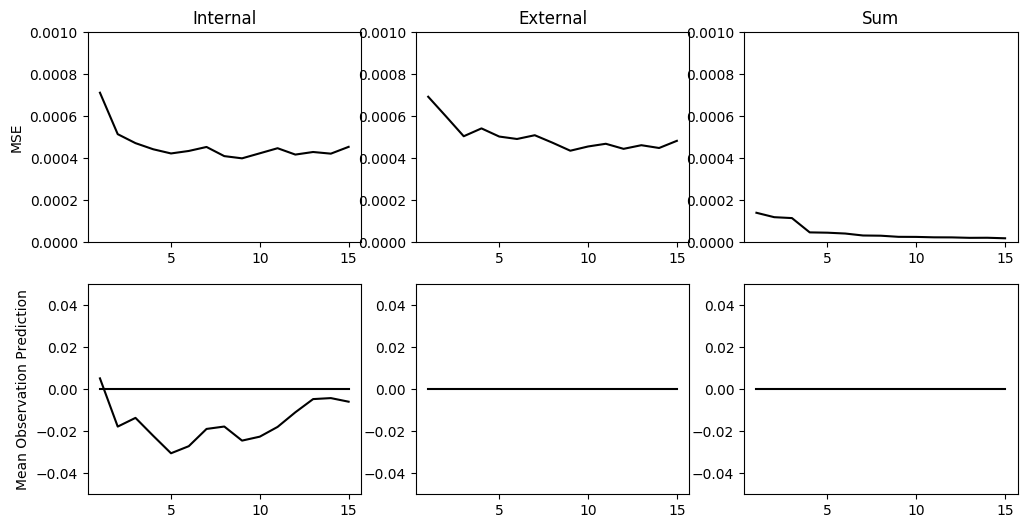

In [23]:
fig, axs = plt.subplots(2,3, figsize=(12,6))
titles = ['Internal', 'External', 'Sum']
for row in range(2):
    for column in range(3):
        if row == 0:
            axs[row,column].plot(np.arange(1,16), metrics_by_pls_comp[:,column, 2], color='black')
            axs[row, column].set_ylim(0.000,0.001)
            axs[row, 0].set_ylabel('MSE')
            axs[row, column].set_title(titles[column])
        if row == 1:
            axs[row,column].plot(np.arange(1,16), metrics_by_pls_comp[:,column, 0], color='black')
            axs[row,column].plot(np.arange(1,16), np.zeros(len(metrics_by_pls_comp[:,column, 0])), color='black')
            axs[row, column].set_ylim(-0.05,0.05)
            axs[row, 0].set_ylabel('Mean Observation Prediction')



/home/disk/p/aodhan/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: Mean of empty slice
  del sys.path[0]


IndexError: invalid index to scalar variable.

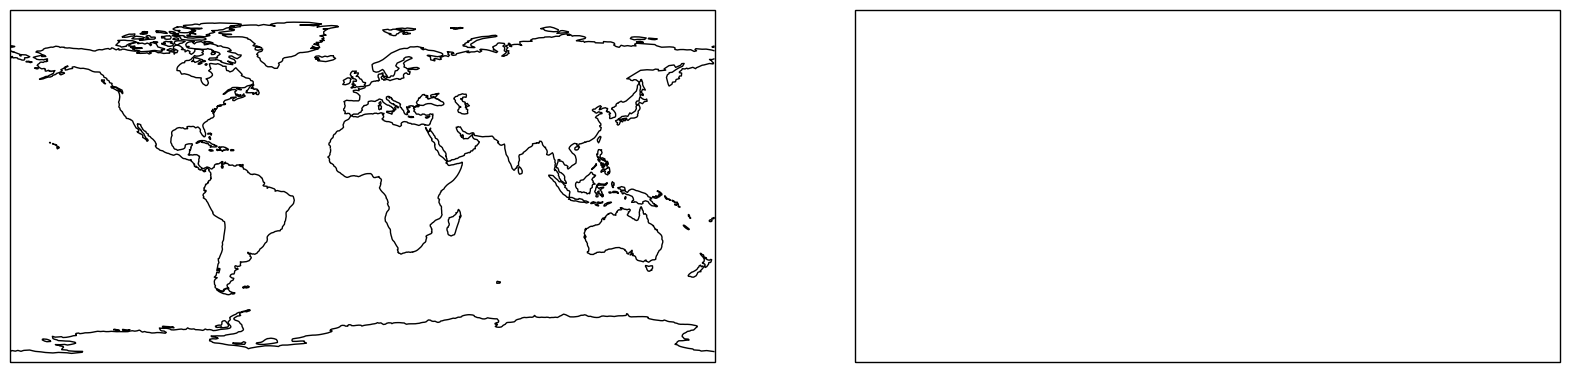

In [21]:
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from matplotlib.colors import LinearSegmentedColormap
# Create Custom Color Map
colors = np.array([(22,98,248), (48,141,250), (71,172,251), (100,201,252), (129,222,253),(162,240,254), (215,249,253), (255,255,255), 
                   (255,255,255), (255,249,217), (247,236,155), (254,221,128), (254,202,100), (255,173,71), (252,142,42), (255,101,15)])/255
custom_cmap = LinearSegmentedColormap.from_list('cmap', colors)

#Plotting is below
lat_bins = np.linspace(-90, 90., 72)
lon_bins = np.linspace(0, 357.5, 144)

mean_coef_maps = np.nanmean(coef_maps, axis=0)

lim = np.linspace(-2e-4, 2e-4, 21)
subplot_kw = dict(projection=ccrs.PlateCarree(central_longitude=0))
fig, ax = plt.subplots(1, 2, figsize=(20, 20), subplot_kw=subplot_kw)
for col in range(2):
    ax[col].coastlines()
    #ax[col].set_title(titles[col])
    map_cyclic, lon = add_cyclic_point(mean_coef_maps[:,:,col], coord=lon_bins)
    im = ax[col].contourf(lon, lat_bins, map_cyclic, levels=lim,
                    transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)




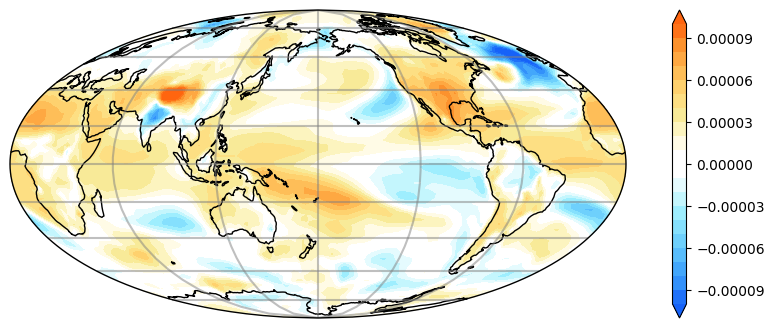

In [22]:
fig =plt.figure(figsize=(12, 4), dpi=100)
cent_lon = 180
ax = plt.axes(projection=ccrs.Mollweide(central_longitude=cent_lon))
levels_of_contour_plot = np.linspace(198, 307, 20)
plt.contourf(lonp, lat, prcpmp[:,:], levels=levels_of_contour_plot, 
             transform=ccrs.PlateCarree(),cmap=custom_cmap)
im = ax.contourf(lon, lat_bins, map_cyclic, levels=lim,
                    transform=ccrs.PlateCarree(), extend='both', cmap=custom_cmap)
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1.5, color='gray', alpha=0.5, linestyle='-')
ax.coastlines()
fig.colorbar(im,  orientation='vertical')
plt.show()

In [9]:
thing = mean_coef_maps[:,:,0]
print(np.shape(thing))

(72, 144)


In [26]:
def area_fraction_finder(lat_top, lat_bottom):
    top_rad = np.deg2rad(lat_top)
    bottom_rad = np.deg2rad(lat_bottom)
    integral_bound_1 = 0.5*(np.sin(top_rad))
    integral_bound_2 = 0.5*(np.sin(bottom_rad))
    area_fraction = integral_bound_1 - integral_bound_2
    return(area_fraction)
area_fraction_finder(lat_top=90, lat_bottom=65)

0.04684610648167503